## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization


## Load Data

In [2]:
high_altitude = pd.read_csv("./data/measurements-high-altitude.csv")
low_altitude = pd.read_csv("./data/measurements-low-altitude.csv")

## Data cleanup

In [3]:
list(high_altitude)

['hour',
 ' minute',
 ' second',
 ' azimuth angle (relative to west=0)/degree',
 ' elevation angle/degree',
 ' power/mW']

In [4]:
high_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
high_altitude.columns = high_altitude.columns.str.replace(" ", "")

low_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
low_altitude.columns = low_altitude.columns.str.replace(" ", "")

In [5]:
high_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,9,45,5,0,0,32
1,9,45,9,0,15,879
2,9,45,12,0,30,34
3,9,45,15,0,45,35
4,9,45,18,0,60,51


In [6]:
low_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,10,38,3,0,0,56
1,10,38,7,0,15,57
2,10,38,10,0,30,59
3,10,38,14,0,45,57
4,10,38,16,0,60,83


In [7]:
high_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000
mean,11.735925,29.474281,29.589307,89.467801,45.006075,231.443904
std,1.498760,17.265160,17.289971,57.050976,30.037962,175.365305
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,15.000000,15.000000,36.000000,15.000000,129.000000
50%,12.000000,30.000000,30.000000,90.000000,45.000000,217.000000
75%,13.000000,45.000000,45.000000,144.000000,75.000000,333.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,4168.000000


In [8]:
high_altitude.loc[high_altitude.power.idxmax(),:]

hour            9
minute         45
second         38
azimuth        18
elevation      45
power        4168
Name: 10, dtype: int64

In [9]:
low_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000
mean,11.880294,30.643139,29.224732,90.000000,45.000000,279.383399
std,1.090955,18.001482,17.335092,56.937075,30.008473,82.632597
min,10.000000,0.000000,0.000000,0.000000,0.000000,41.000000
25%,11.000000,14.000000,14.000000,36.000000,15.000000,225.000000
50%,12.000000,32.000000,29.000000,90.000000,45.000000,302.000000
75%,13.000000,47.000000,44.000000,144.000000,75.000000,352.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,378.000000


### Convert time in seconds

In [10]:
def get_seconds(h, m, s):
  s_vec = []
  for i in range(len(s)):
    s_vec.append(h[i]*3600 + m[i]*60 + s[i])
  return s_vec

In [11]:
h, m, s = low_altitude.hour.tolist(), low_altitude.minute.tolist(), low_altitude.second.tolist()
seconds = get_seconds(h,m,s)
low_altitude.drop(columns=["hour", "minute", "second"], inplace=True)
low_altitude["seconds"] = seconds

In [12]:
h, m, s = high_altitude.hour.tolist(), high_altitude.minute.tolist(), high_altitude.second.tolist()
seconds = get_seconds(h,m,s)
high_altitude.drop(columns=["hour", "minute", "second"], inplace=True)
high_altitude["seconds"] = seconds

### Removing outliers from high_altitude

In [13]:
high_altitude.shape


(2469, 4)

In [14]:
high_altitude = high_altitude[(np.abs(stats.zscore(high_altitude)) < 3).all(axis=1)]

In [15]:
high_altitude.shape

(2459, 4)

### Plots

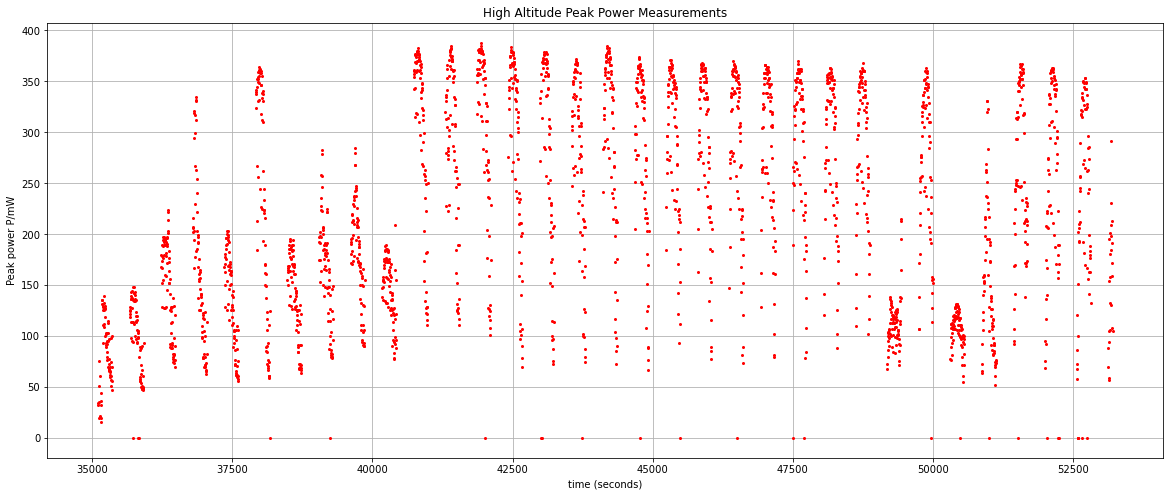

In [16]:
plt.figure(figsize=(20,8))
plt.plot(high_altitude.seconds, high_altitude.power, 'or', markersize=2)
plt.title("High Altitude Peak Power Measurements")
plt.xlabel("time (seconds)")
plt.ylabel("Peak power P/mW")
plt.grid()

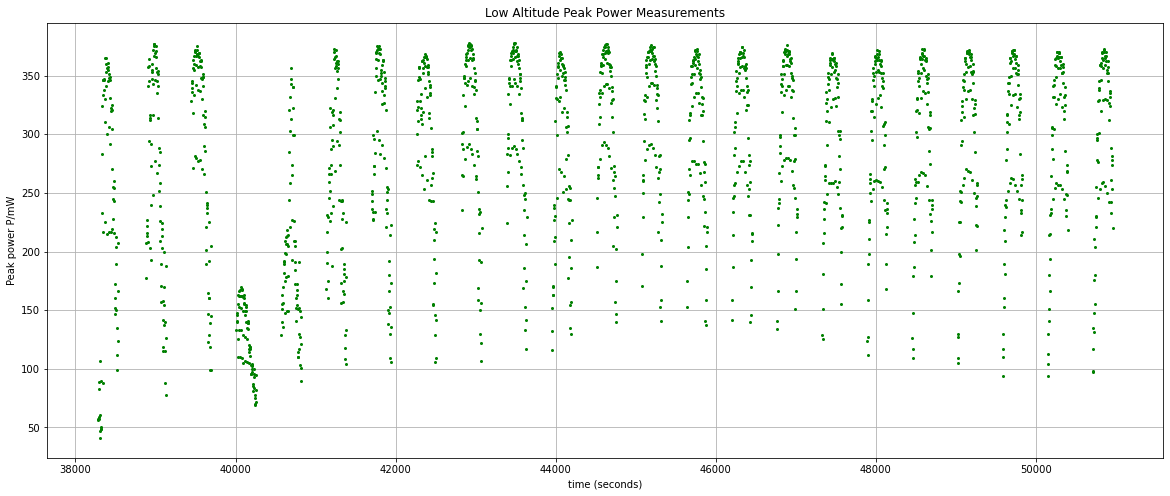

In [17]:
plt.figure(figsize=(20,8))
plt.plot(low_altitude.seconds, low_altitude.power, 'og', markersize=2)
plt.title("Low Altitude Peak Power Measurements")
plt.xlabel("time (seconds)")
plt.ylabel("Peak power P/mW")
plt.grid()

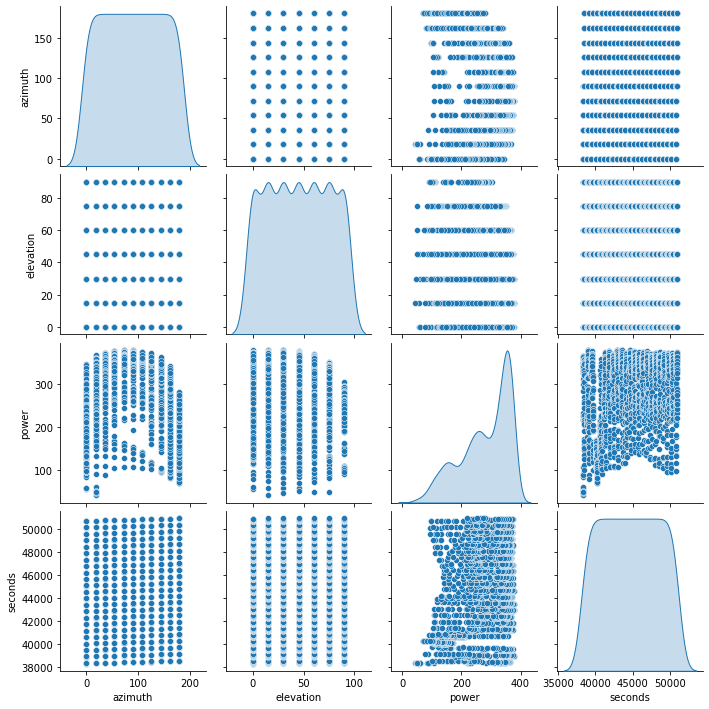

In [18]:
sns.pairplot(low_altitude, diag_kind='kde')

## Train test split

In [19]:
X_low_train = low_altitude.sample(frac=0.8, random_state=2)
X_low_test = low_altitude.drop(X_low_train.index)

y_low_train = X_low_train.pop("power")
y_low_test = X_low_test.pop("power")

In [20]:
X_high_train = high_altitude.sample(frac=0.8, random_state=2)
X_high_test = high_altitude.drop(X_high_train.index)

y_high_train = X_high_train.pop("power")
y_high_test = X_high_test.pop("power")

In [21]:
y_low_train.describe()

count    1417.000000
mean      279.540579
std        82.386542
min        49.000000
25%       227.000000
50%       301.000000
75%       351.000000
max       378.000000
Name: power, dtype: float64

In [22]:
y_high_train.describe()

count    1967.000000
mean      224.564311
std       104.227067
min         0.000000
25%       129.000000
50%       216.000000
75%       333.000000
max       388.000000
Name: power, dtype: float64

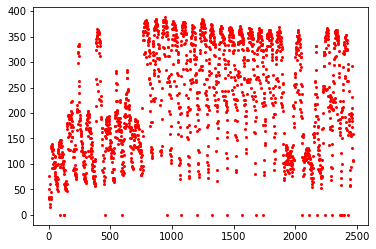

In [23]:
plt.plot(y_high_train, 'or', markersize=2)

In [24]:
normalizer_low = Normalization(axis=-1)
normalizer_low.adapt(np.array(X_low_train))

print(normalizer_low.mean.numpy())

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-24 18:18:10.548986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-24 18:18:10.549281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-24 18:18:10.599574: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-24 18:18:10.667995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-24 18:18:10.684754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[   88.81864     45.719826 44603.668   ]]


In [25]:
first_sample = np.array(X_low_train[:1])

with np.printoptions(precision=2, suppress=True):
  print(np.sort(first_sample))
  print(np.sort(normalizer_low(first_sample).numpy()))


[[    0    15 42266]]
[[-1.56 -1.02 -0.62]]


# Baseline Dataset

## Regression using MLP

In [26]:
def create_regressor(normalizer):
  reg = Sequential([
  normalizer,
  Dense(units=256, activation='relu'),
  Dropout(0.3),
  Dense(units=128, activation='relu'),
  Dense(units=1)
])

  return reg

In [27]:
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-10, verbose=1), tf.keras.callbacks.EarlyStopping(patience=30)]
metrics = [tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()]

In [28]:
def plot_metrics(history):

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.set_size_inches(20,10)
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_title('loss (MAE)')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('error')
  plt.legend()
  plt.grid(True)

  ax2.plot(history.history['mean_absolute_percentage_error'], label='mape')
  ax2.plot(history.history['val_mean_absolute_percentage_error'], label='val_mape')
  ax2.set_title('metric (MAPE)')
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('error')
  plt.legend()
  plt.grid(True)

  ax3.plot(history.history['mean_squared_error'], label='mse')
  ax3.plot(history.history['val_mean_squared_error'], label='val_mse')
  ax3.set_title('metric (MSE)')
  ax3.set_xlabel('epochs')
  ax3.set_ylabel('error')
  plt.legend()
  plt.grid(True)

### Regression on Low Altitude

In [29]:
reg_low = create_regressor(normalizer_low)
reg_low.predict(X_low_train[:10])

2022-06-24 18:18:11.085285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[-0.01086766],
       [ 0.04165885],
       [-0.04710188],
       [ 0.04052248],
       [ 0.04601636],
       [ 0.06425264],
       [-0.1418032 ],
       [-0.02829139],
       [ 0.10180127],
       [-0.08921482]], dtype=float32)

In [30]:
reg_low.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               1024      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,056
Trainable params: 34,049
Non-trainable params: 7
____________________________________________________

In [31]:
reg_low.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mae", metrics=metrics)

In [32]:
history = reg_low.fit(X_low_train, y_low_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
 1/36 [..............................] - ETA: 9s - loss: 282.6165 - mean_absolute_percentage_error: 100.0114 - mean_squared_error: 85032.4219

2022-06-24 18:18:11.369895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 13ms/step - loss: 121.6459 - mean_absolute_percentage_error: 51.4886 - mean_squared_error: 23379.4121 - val_loss: 69.0290 - val_mean_absolute_percentage_error: 36.3026 - val_mean_squared_error: 8787.9316 - lr: 0.1000
Epoch 2/1000
 8/36 [=====>........................] - ETA: 0s - loss: 84.7363 - mean_absolute_percentage_error: 37.1930 - mean_squared_error: 10993.6875

2022-06-24 18:18:11.890072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 9ms/step - loss: 65.9333 - mean_absolute_percentage_error: 30.6984 - mean_squared_error: 7213.4741 - val_loss: 42.7318 - val_mean_absolute_percentage_error: 19.5300 - val_mean_squared_error: 3071.9680 - lr: 0.1000
Epoch 3/1000
36/36 [==============================] - 0s 8ms/step - loss: 52.5778 - mean_absolute_percentage_error: 25.9515 - mean_squared_error: 4846.0825 - val_loss: 38.1118 - val_mean_absolute_percentage_error: 20.3605 - val_mean_squared_error: 2763.3091 - lr: 0.1000
Epoch 4/1000
36/36 [==============================] - 0s 8ms/step - loss: 45.0984 - mean_absolute_percentage_error: 23.1330 - mean_squared_error: 3765.5681 - val_loss: 47.6210 - val_mean_absolute_percentage_error: 18.4398 - val_mean_squared_error: 3127.9797 - lr: 0.1000
Epoch 5/1000
36/36 [==============================] - 0s 8ms/step - loss: 49.3758 - mean_absolute_percentage_error: 24.0006 - mean_squared_error: 4146.3530 - val_loss: 38.3091 - val_mean_absolute_perc

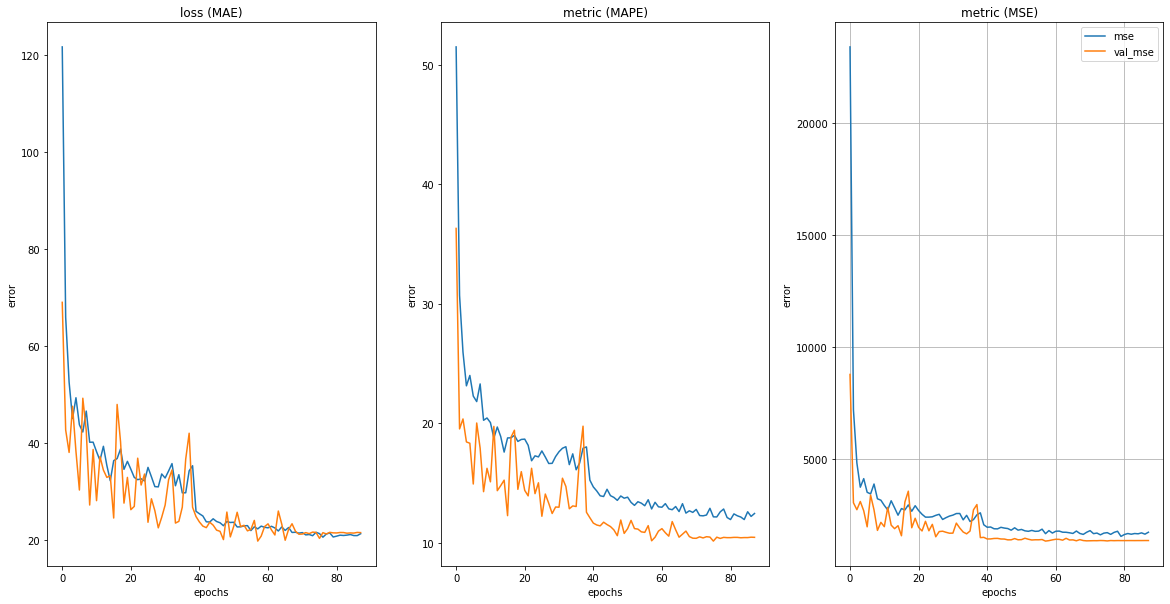

In [33]:
plot_metrics(history)

In [34]:
results = reg_low.evaluate(X_low_test, y_low_test)

12/12 [==============================] - 0s 7ms/step - loss: 22.4964 - mean_absolute_percentage_error: 12.3993 - mean_squared_error: 1608.7816


### Regression on High Altitude

In [35]:
normalizer_high = Normalization(axis=-1)
normalizer_high.adapt(np.array(X_high_train))

print(normalizer_high.mean.numpy())

[[   89.49671     45.289783 44092.188   ]]


2022-06-24 18:18:41.805108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-24 18:18:41.816649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [36]:
first_sample = np.array(X_high_train[:1])

with np.printoptions(precision=2, suppress=True):
  print(np.sort(first_sample))
  print(np.sort(normalizer_high(first_sample).numpy()))

[[   15   144 42050]]
[[-1.01 -0.39  0.96]]


In [37]:
reg_high = create_regressor(normalizer_high)
reg_high.predict(X_high_train[:10])

2022-06-24 18:18:42.075965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[-0.02107408],
       [-0.00855254],
       [ 0.02921541],
       [-0.04107896],
       [-0.01474341],
       [-0.02974968],
       [-0.09367929],
       [ 0.05411949],
       [ 0.06041685],
       [ 0.00877886]], dtype=float32)

In [38]:
reg_high.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 256)               1024      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,056
Trainable params: 34,049
Non-trainable params: 7
__________________________________________________

In [39]:
reg_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mae', metrics=metrics)

In [40]:
history = reg_high.fit(X_high_train, y_high_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
 8/50 [===>..........................] - ETA: 0s - loss: 155.7619 - mean_absolute_percentage_error: 400578432.0000 - mean_squared_error: 16138.9590

2022-06-24 18:18:42.291283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 11ms/step - loss: 100.4116 - mean_absolute_percentage_error: 1685143296.0000 - mean_squared_error: 14253.1377 - val_loss: 59.8555 - val_mean_absolute_percentage_error: 2709289216.0000 - val_mean_squared_error: 6587.4150 - lr: 0.1000
Epoch 2/1000
 9/50 [====>.........................] - ETA: 0s - loss: 70.2211 - mean_absolute_percentage_error: 2936364544.0000 - mean_squared_error: 8657.0752

2022-06-24 18:18:42.849910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 0s 8ms/step - loss: 66.1033 - mean_absolute_percentage_error: 2753469952.0000 - mean_squared_error: 7419.2715 - val_loss: 79.0326 - val_mean_absolute_percentage_error: 1489747712.0000 - val_mean_squared_error: 9146.9072 - lr: 0.1000
Epoch 3/1000
50/50 [==============================] - 0s 8ms/step - loss: 64.8929 - mean_absolute_percentage_error: 2409479168.0000 - mean_squared_error: 6992.6782 - val_loss: 48.2992 - val_mean_absolute_percentage_error: 2162117376.0000 - val_mean_squared_error: 4161.6079 - lr: 0.1000
Epoch 4/1000
50/50 [==============================] - 0s 8ms/step - loss: 64.2380 - mean_absolute_percentage_error: 2481867776.0000 - mean_squared_error: 7152.1074 - val_loss: 69.7809 - val_mean_absolute_percentage_error: 1739997568.0000 - val_mean_squared_error: 7608.5415 - lr: 0.1000
Epoch 5/1000
50/50 [==============================] - 0s 8ms/step - loss: 55.4794 - mean_absolute_percentage_error: 2492082176.0000 - mean_squared_error

KeyboardInterrupt: 

In [ ]:
plot_metrics(history)

In [ ]:
results = reg_high.evaluate(X_high_test, y_high_test)